In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import calendar
plt.style.use('ggplot')
import seaborn as sns
import datetime
pd.set_option('display.max_columns', 500)
from scipy.stats import ttest_ind,boxcox,chi2_contingency

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from state_abbr import states as states_dict

FIG_SIZE = (15,5)

In [2]:
size = 'medium' # ['small','medium','large']
flights = pd.read_csv("flights_{0}.csv".format(size))
flights["Date"] = pd.to_datetime(flights["Date"])
n,m = flights.shape
any_nans = flights.isnull().values.any()
print("n observations = {0:,}. n features = {1}. Any NANs = {2}".format(n,m,any_nans))

n observations = 1,000,000. n features = 19. Any NANs = False


### Get year, month of flight and add full departure state name

In [3]:
flights.insert(loc=1,column="month",value=pd.DatetimeIndex(flights['Date']).month)
flights.insert(loc=1,column="year",value=pd.DatetimeIndex(flights['Date']).year)
flights['Departure_State_Full'] = flights.Departure_State.apply(lambda state: states_dict[state])
flights[["Date","year","month",'Departure_State_Full','Departure_State']].head(20)

,Date,year,month,Departure_State_Full,Departure_State
0,2009-04-24,2009,4,Connecticut,CT
1,2009-04-29,2009,4,Connecticut,CT
2,2010-04-30,2010,4,Connecticut,CT
3,2010-04-15,2010,4,Connecticut,CT
4,2010-12-24,2010,12,Connecticut,CT
5,2010-04-27,2010,4,Connecticut,CT
6,2010-09-22,2010,9,Connecticut,CT
7,2008-10-09,2008,10,Connecticut,CT
8,2008-12-01,2008,12,Florida,FL
9,2010-01-18,2010,1,Georgia,GA


### What is the trend over time in number of flights?

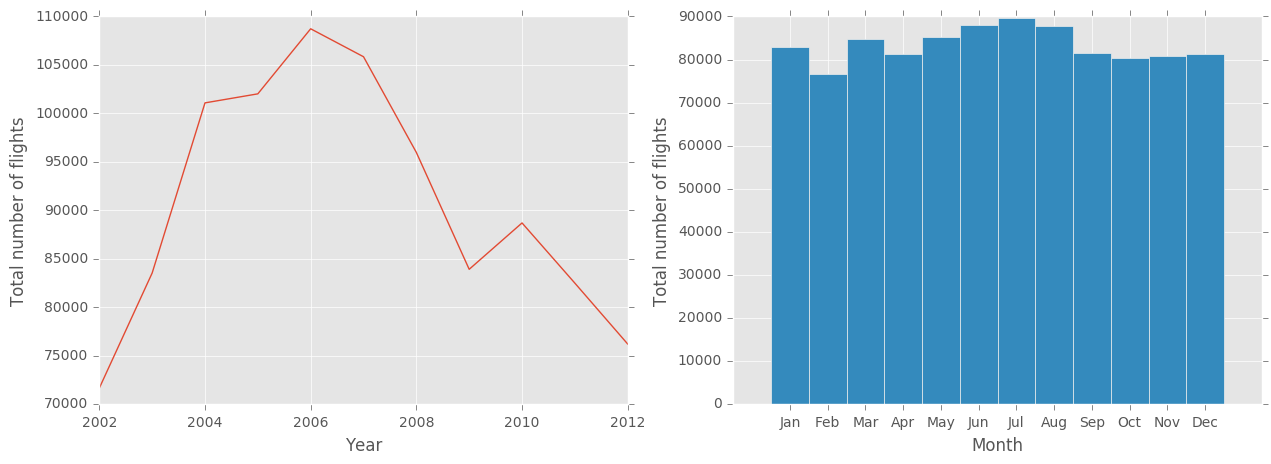

In [4]:
flights_by_year = flights.groupby('year').size()
flights_by_month = flights.groupby('month').size()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
months = flights_by_month.index 
months_names = [calendar.month_abbr[mon] for mon in months]
width=1.0
ax1.plot(flights_by_year); ax1.set_xlabel("Year"); ax1.set_ylabel("Total number of flights")
ax2.bar(months,flights_by_month,width=width); ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Total number of flights")
plt.show()

* Flights by year shows decrease in total annual flights after 2006. Possibly due to financial crash.
* Flights by month differences might possibly be related to US holidays.

### Departure traffic by state

In [8]:
state_dep_counts = pd.DataFrame(flights["Departure_State"].value_counts())
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(type='choropleth', colorscale = scl, autocolorscale = False,
        locations = state_dep_counts.index,
        z = state_dep_counts['Departure_State'].astype(float),
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "Departure total traffic")
    ) ]

layout = dict(title = 'Departure total traffic',
        geo = dict(scope='usa',projection=dict( type='albers usa' ),showlakes = True,lakecolor = 'rgb(255, 255, 255)'),
    )
fig = dict( data=data, layout=layout )
iplot(data)  

# Delay times? 

[Top reasons for delays](http://www.mro-network.com/maintenance-repair-overhaul/top-5-reasons-flight-delays/gallery?slide=5)
* late arriving aircraft - can't obtain this feature as we don't have a unique plane id in dataset.
* air carrier delays - no info
* heavy traffic volume - can model this
* extreme weather - can model this
* security lines - no info.

### Delays are highly skewed (focus on departure delays as opposed to arrivals)

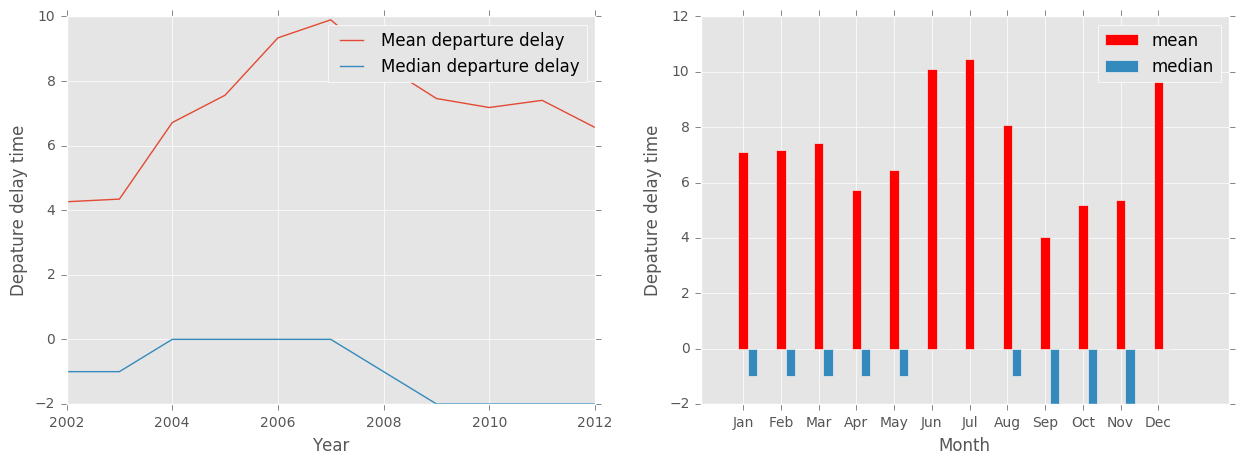

In [9]:
departure_delay_year = flights[["Departure_delay","year"]].groupby("year").agg(["mean","median"]) 
departure_delay_month = flights[["Departure_delay","month"]].groupby('month').agg(["mean","median"])
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
ax1.plot(departure_delay_year)
ax1.legend(("Mean departure delay","Median departure delay"))
ax1.set_ylabel("Depature delay time"); ax1.set_xlabel("Year")

width = 0.25
ax2.bar(months,departure_delay_month["Departure_delay"]["mean"].values,width=width,color='red');
ax2.bar(months+width,departure_delay_month["Departure_delay"]["median"].values,width=width);
ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Depature delay time")
ax2.legend(("mean","median"))
plt.show()

* Delays seem to be correlated with overall traffic. E.g. delays are more likely to be long in high traffic months such as june, july as well as high traffic years e.g. 2006. 
* Delays also very higher in winter months as expected.
* Mean >> Median implying positivley skewed delays. I.e there are few very long delays

### Remove 'quick' flights, outliers and visualize log delays

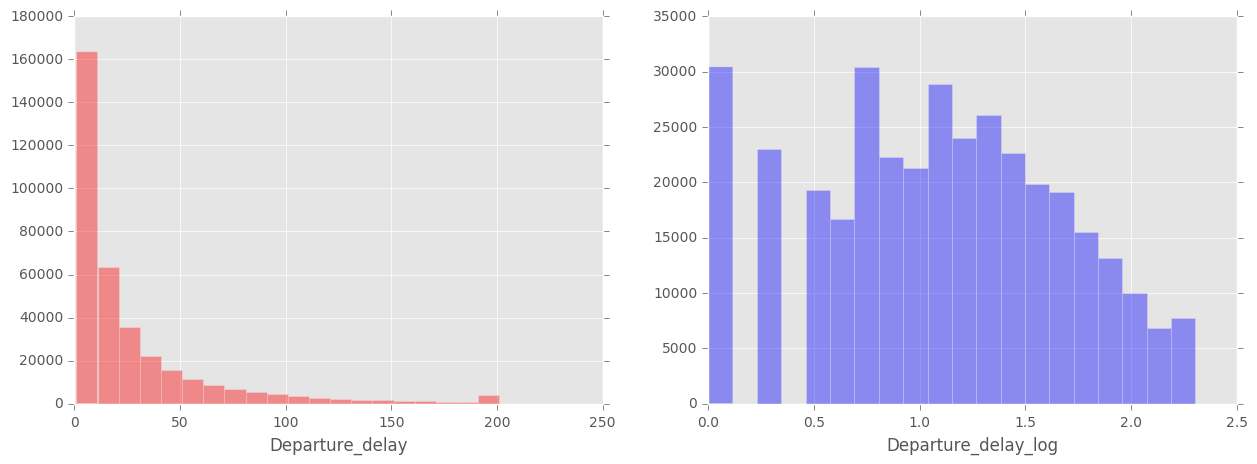

In [11]:
flights = flights[flights['Departure_delay']>0] # not interested in 'quick' flights. Helps with sampling underrepresented long delay examples when trying to predict later on.
quantile_upper_clip = np.percentile(flights['Departure_delay'],99)
flights['Departure_delay'] = flights.Departure_delay.clip_upper(quantile_upper_clip) #anything bigger than 99th percentile set to 99th quntile

flights['Departure_delay_log'] = flights['Departure_delay'].apply(lambda x: np.log10(x))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.distplot(flights['Departure_delay'],ax=ax1,label='delays',color='red',bins=20,kde=False)
sns.distplot(flights['Departure_delay_log'],ax=ax2,label='log delays',color='blue',bins=20,kde=False); plt.show()

* If predicting continous variable, $log_{10}$ version may be better

### Bin Departure delay into (0-15], (15-60],(60,inf)

In [16]:
flights['Departure_delay_bin'] = pd.cut(flights['Departure_delay'],
                                        bins=(0,15,60,quantile_upper_clip+1),
                                        labels=("No delay","Short delay","Long Delay"))
flights['Departure_delay_bin'].value_counts()/flights.shape[0]

No delay       0.561114
Short delay    0.311899
Long Delay     0.126986
Name: Departure_delay_bin, dtype: float64

### Functions to use later on

In [100]:
class Cross_tab(): # cross tabulate two variables and do chi2 test of independence. reject if p value is small i.e. good predictor
    def __init__(self,var1,var2):
        self.cross_tab = pd.crosstab(var1,var2)
        
    def chi2_test(self,alpha=0.01):
        chi2_test = chi2_contingency(self.cross_tab)
        self.pval = chi2_test[1]
        if self.pval < alpha:
            result = 'reject independence'
        else:
            result = 'accept null of independence'
        print(self.cross_tab)
        print(self.cross_tab.div(self.cross_tab.sum(axis=1),axis=0))
        print('\n P value = {0:.6f}. {1}'.format(self.pval,result))

def plot_two_dist(dist1,dist2,title_append=''): # plot function used later
    dist1_n, dist2_n = dist1['values'].size, dist2['values'].size
    f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
    sns.distplot(dist1['values'],ax=ax1,label=dist1['name'],color='red',bins=15)
    sns.distplot(dist2['values'],ax=ax1,label=dist2['name'],color='blue',bins=15)
    ax1.vlines(dist1['values'].mean(), 0, 1,colors='red')
    ax1.vlines(dist2['values'].mean(), 0, 1,colors='blue')
    plt.title("Counts for {0}={1}, {2}={3}. {4}".format(dist1['name'],dist1_n,
                                                   dist2['name'],dist2_n,
                                                     title_append))
    plt.legend()
    plt.show()

### Delays arguably related to weather which is related to location. Should see relationship between latitude ("north-south") and delay time

In [71]:
flights['latitude_bin'] = np.where(flights.Latitude>40,'north','south') # anything above 40 lat classes as north
Lat_contingency = Cross_tab(flights['latitude_bin'],flights['Departure_delay_bin'])
Lat_contingency.chi2_test()

Departure_delay_bin  No delay  Short delay  Long Delay
latitude_bin                                          
north                   54402        30683       14122
south                  146092        80763       31252

 P value = 0.0000. reject independence


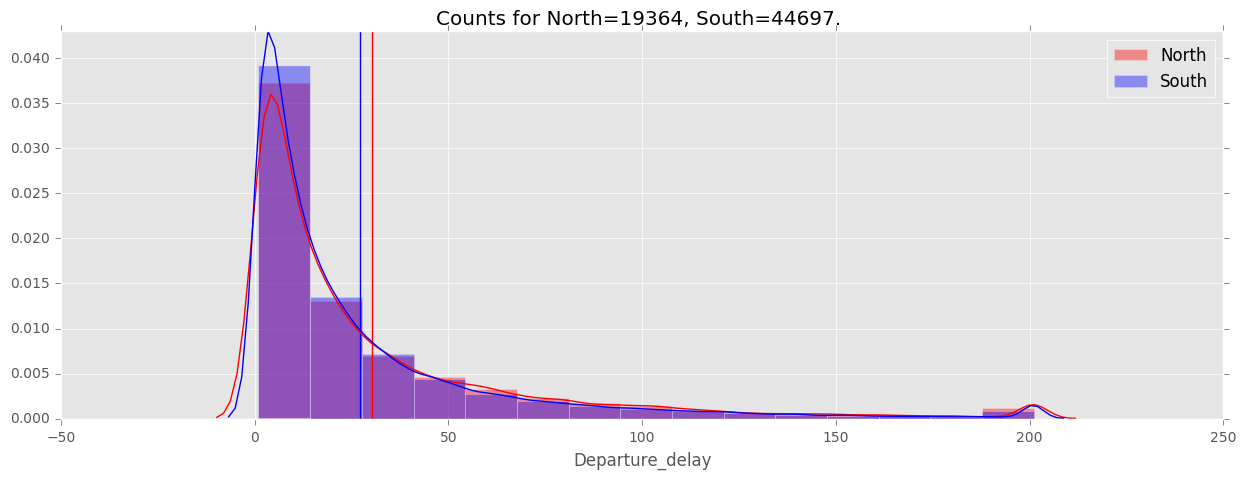

In [21]:
flights_winter = flights[flights['month'].isin([1,12])] # winter months
north_delays_winter = flights_winter[(flights_winter['latitude_bin']=='north')]['Departure_delay']
south_delays_winter = flights_winter[(flights_winter['latitude_bin']=='south')]['Departure_delay']
dist1={'values':north_delays_winter,'name':'North'}
dist2={'values':south_delays_winter,'name':'South'}
plot_two_dist(dist1,dist2)

* some difference in continous departure delays. possibly need specific weather information
* we do reject null hypothesis of independence between departure_delay_bins and our latitude variable however

### Load weather, look at wind/snow by date and aiport (departure airport)

In [72]:
weather = pd.read_csv("weather.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather = weather.rename(columns={"airport": "Departure_Airport"})

### if snow and rain do not change (i.e. std==0) by day at each airport then we can just merge our flight data and weather data and keep any one of the time values

In [74]:
weather_by_date_airport = weather[['snow','wind',"Date","Departure_Airport"]].groupby(["Date","Departure_Airport"]).agg(['std'])
np.any(weather_by_date_airport>0) # snow and rain values do not change each day given an airport.
weather.drop('time',axis=1,inplace=True) # therefore time is redundant
weather.drop_duplicates(inplace=True) 
flights_weather = flights.merge(weather,how='left',on=["Date","Departure_Airport"], indicator=True) # merge with flight data.

### assume null = 0. i.e. no entry has been entered into dataset if no snow or wind

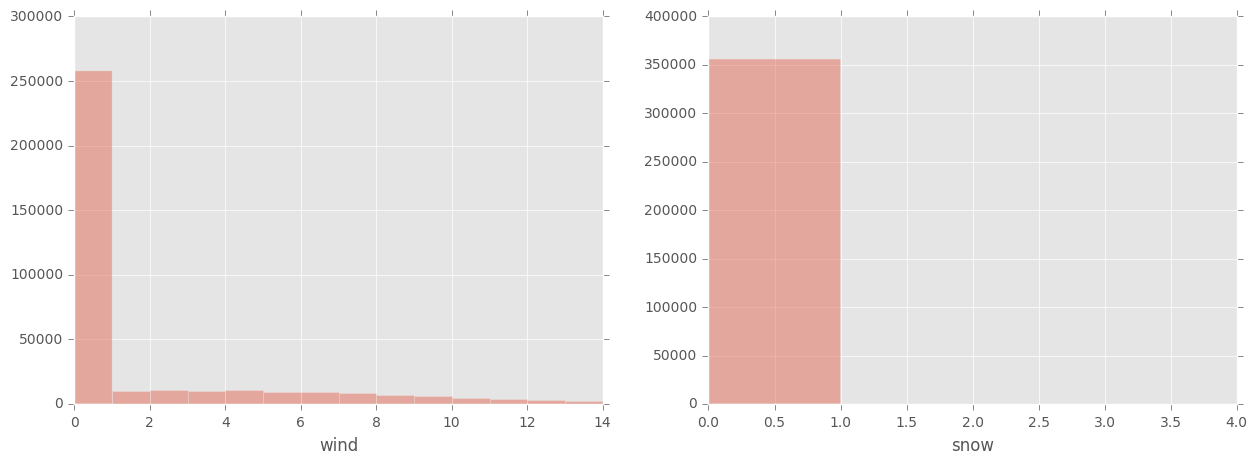

In [76]:
flights_weather[['snow','wind']] = flights_weather[['snow','wind']].fillna(0)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.distplot(flights_weather.wind,bins=np.arange(0,15,1),ax=ax1,label='wind',kde=False)
sns.distplot(flights_weather.snow,bins=np.arange(0,5,1),ax=ax2,label='snow',kde=False)
plt.show()

* Incredibly sparse variables, best to bin

### Check delay distribution by whether or not snow was present. Loop over a snow threshold

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45232    200099       111096
True                        142       395          350
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126904  0.561402     0.311694
True                   0.160090  0.445321     0.394589

 P value = 0.0000. reject independence


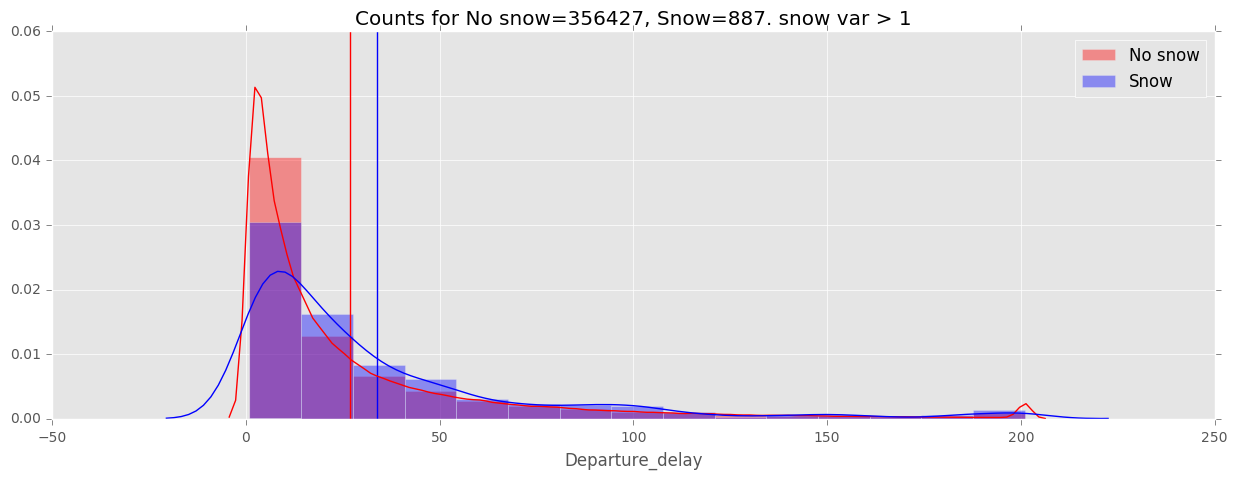

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45298    200287       111260
True                         76       207          186
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126940  0.561272     0.311788
True                   0.162047  0.441365     0.396588

 P value = 0.0000. reject independence


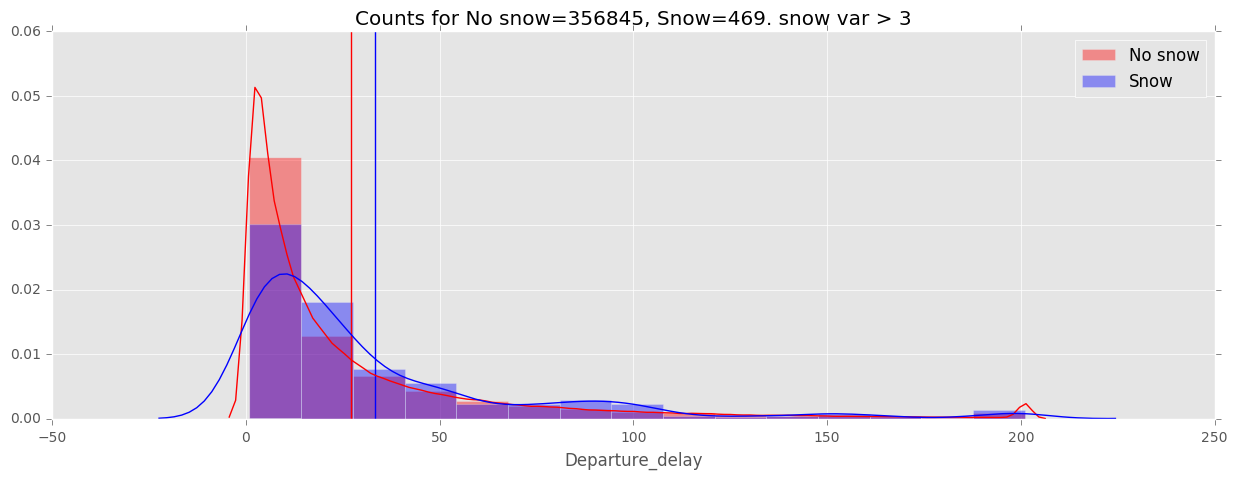

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45343    200392       111350
True                         31       102           96
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126981  0.561189     0.311831
True                   0.135371  0.445415     0.419214

 P value = 0.0009. reject independence


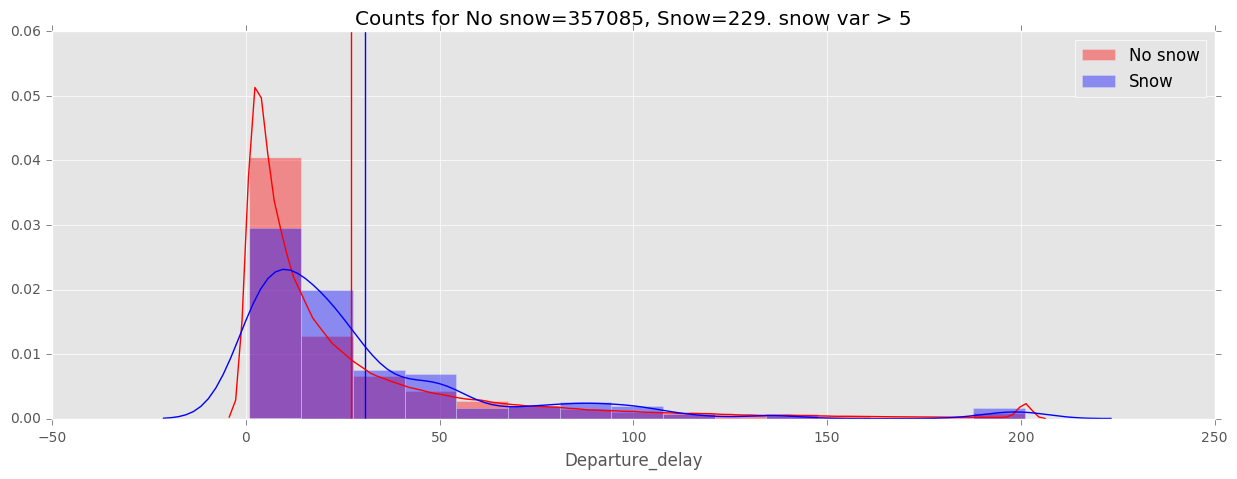

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45355    200449       111397
True                         19        45           49
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126973  0.561166     0.311861
True                   0.168142  0.398230     0.433628

 P value = 0.0022. reject independence


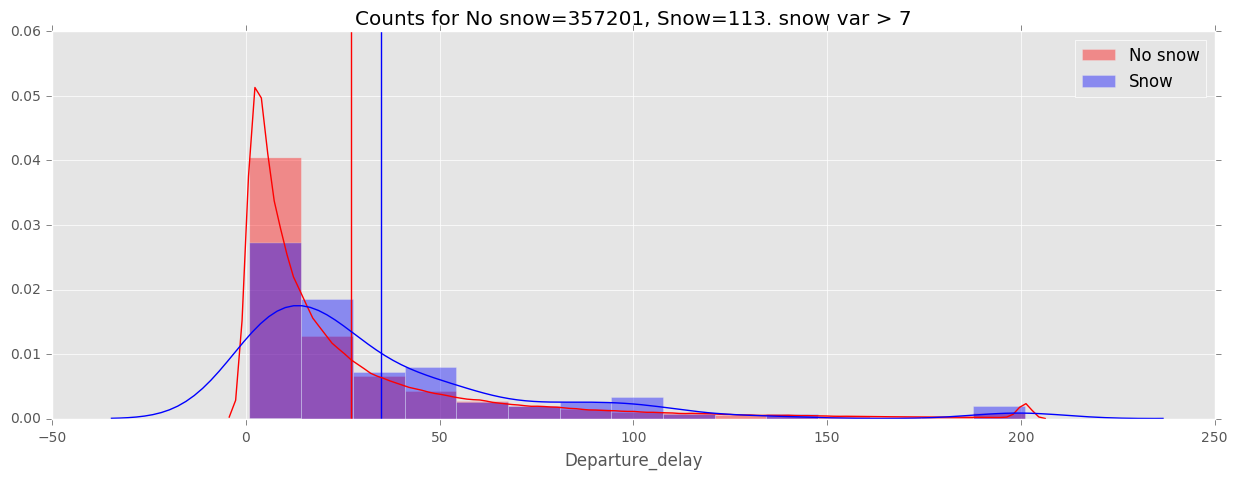

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45363    200470       111418
True                         11        24           28
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126978  0.561146     0.311876
True                   0.174603  0.380952     0.444444

 P value = 0.0156. accept null of independence


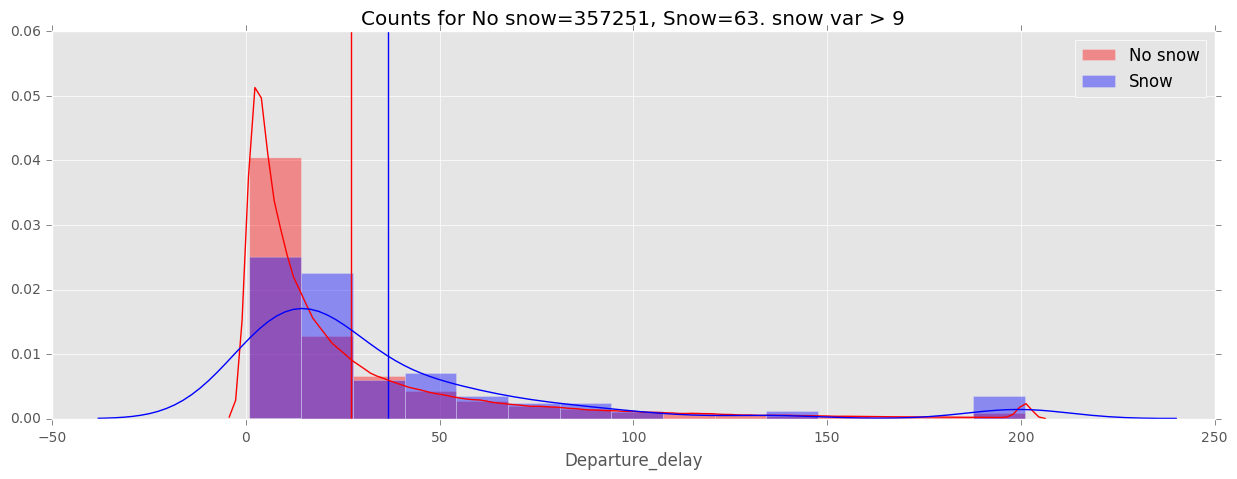

Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                     45368    200481       111438
True                          6        13            8
Departure_delay_bin  Long Delay  No delay  Short delay
snow_bool                                             
False                  0.126979  0.561120     0.311901
True                   0.222222  0.481481     0.296296

 P value = 0.3239. accept null of independence


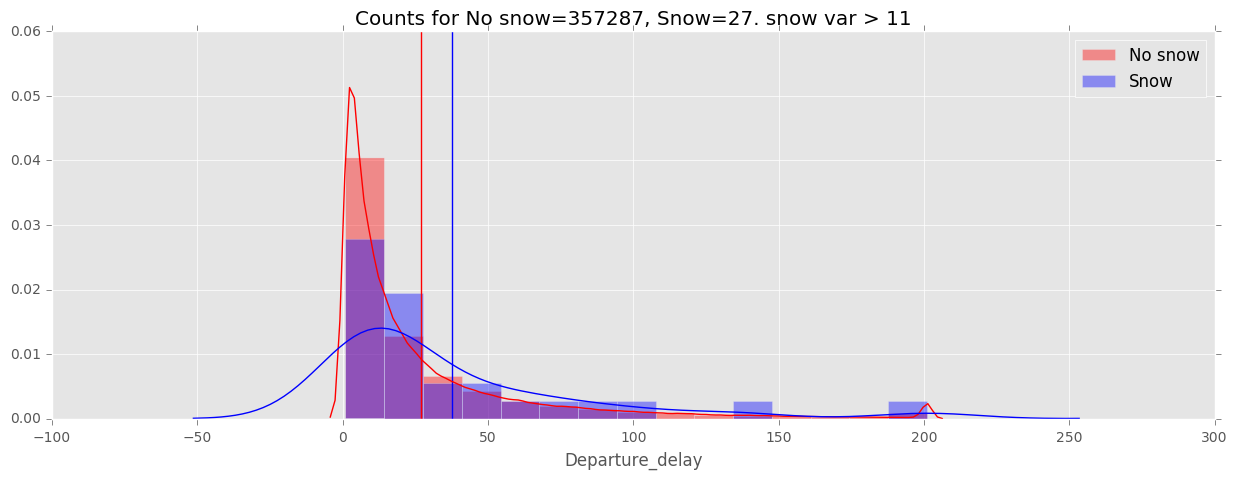

In [95]:
for snow_value in range(1,12,2):
    flights_weather['snow_bool'] = flights_weather[['snow']] > snow_value
    snow_contingency = Cross_tab(flights_weather['snow_bool'],flights_weather['Departure_delay_bin'])
    snow_contingency.chi2_test()
    
    #plot
    no_snow = flights_weather['Departure_delay'][flights_weather.snow_bool==0]
    snow = flights_weather['Departure_delay'][flights_weather.snow_bool==1]
    dist1={'values':no_snow,'name':'No snow'}
    dist2={'values':snow,'name':'Snow'}
    title = 'snow var > {0}'.format(snow_value)
    plot_two_dist(dist1,dist2,title_append=title)
flights_weather['snow_bool'] = flights_weather[['snow']] > 1 

* small difference in distributions which gets greater the higher the threshold of 'snow_bool'. Number of events gets very small however.
* contingency pvalue strongest at snow_bool > 1

### Do the same but with wind. No plots this time, just contingency.

In [101]:
for wind_value in range(1,20,4):
    print("\n\nWind = " + str(wind_value))
    flights_weather['wind_bin'] = flights_weather['wind'] > wind_value
    snow_contingency = Cross_tab(flights_weather['wind_bin'],flights_weather['Departure_delay_bin'])
    snow_contingency.chi2_test()
    
    #plot
    #no_wind = flights_weather['Departure_delay'][flights_weather.wind_bin==0]
    #wind = flights_weather['Departure_delay'][flights_weather.wind_bin>0]
    #dist1={'values':no_wind,'name':'No wind'}
    #dist2={'values':wind,'name':'Wind'}
    #title = 'Wind thresh > {0}'.format(wind_value)
    #plot_two_dist(dist1,dist2,title)



Wind = 1
Departure_delay_bin  Long Delay  No delay  Short delay
wind_bin                                              
False                     32607    147212        78966
True                      12767     53282        32480
Departure_delay_bin  Long Delay  No delay  Short delay
wind_bin                                              
False                  0.126000  0.568858     0.305141
True                   0.129576  0.540775     0.329649

 P value = 0.000000. reject independence


Wind = 5
Departure_delay_bin  Long Delay  No delay  Short delay
wind_bin                                              
False                     37886    170274        92417
True                       7488     30220        19029
Departure_delay_bin  Long Delay  No delay  Short delay
wind_bin                                              
False                  0.126044  0.566490     0.307465
True                   0.131977  0.532633     0.335390

 P value = 0.000000. reject independence


Wind = 9
Dep

### Ice or no ice (sub zero). Assume mean temperature for missing

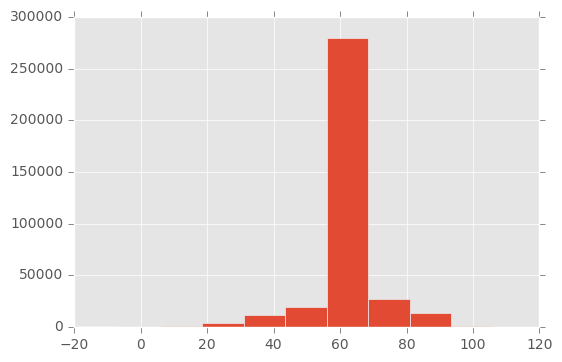

In [81]:
flights_weather.temperature.fillna(flights_weather.temperature.mean(),inplace=True)
plt.hist(flights_weather['temperature']); plt.show()

* Must be in farenheit

Departure_delay_bin  Long Delay  No delay  Short delay
sub_zero                                              
False                     44470    197324       109215
True                        904      3170         2231
Departure_delay_bin  Long Delay  No delay  Short delay
sub_zero                                              
False                  0.126692  0.562162     0.311146
True                   0.143378  0.502776     0.353846

 P value = 0.000000. reject independence


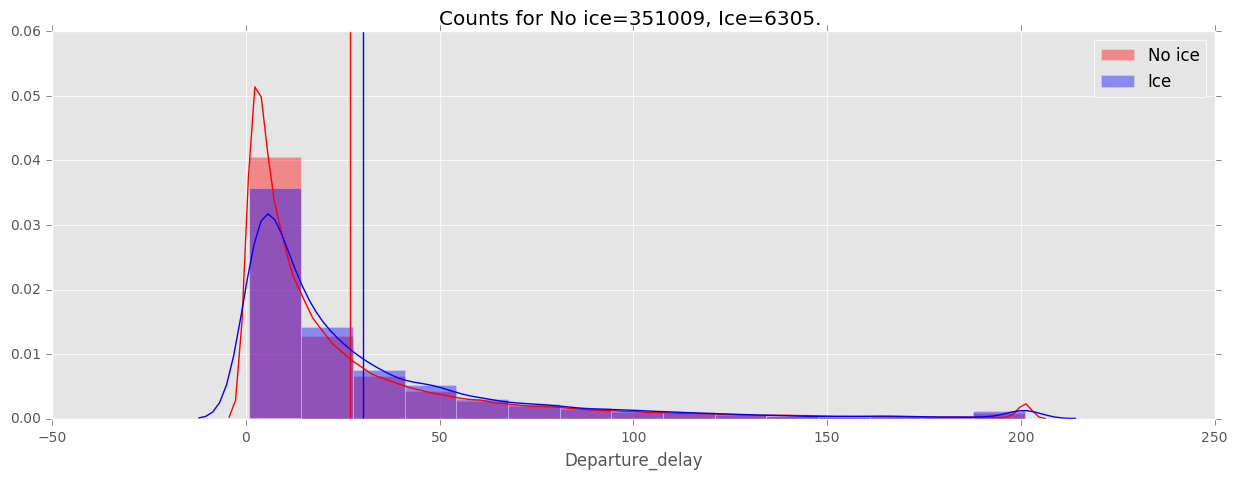

In [102]:
flights_weather['sub_zero'] = flights_weather['temperature'] < 32 #0C = 32F
snow_contingency = Cross_tab(flights_weather['sub_zero'],flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_ice = flights_weather['Departure_delay'][flights_weather.sub_zero==False] ## may not be actual ice, just a name.
ice = flights_weather['Departure_delay'][flights_weather.sub_zero==True]
dist1={'values':no_ice,'name':'No ice'}
dist2={'values':ice,'name':'Ice'}
plot_two_dist(dist1,dist2)

* "Ice" is quite rare event but looks like it increases delays
* Reject our null of independence

### Flights delays by airport

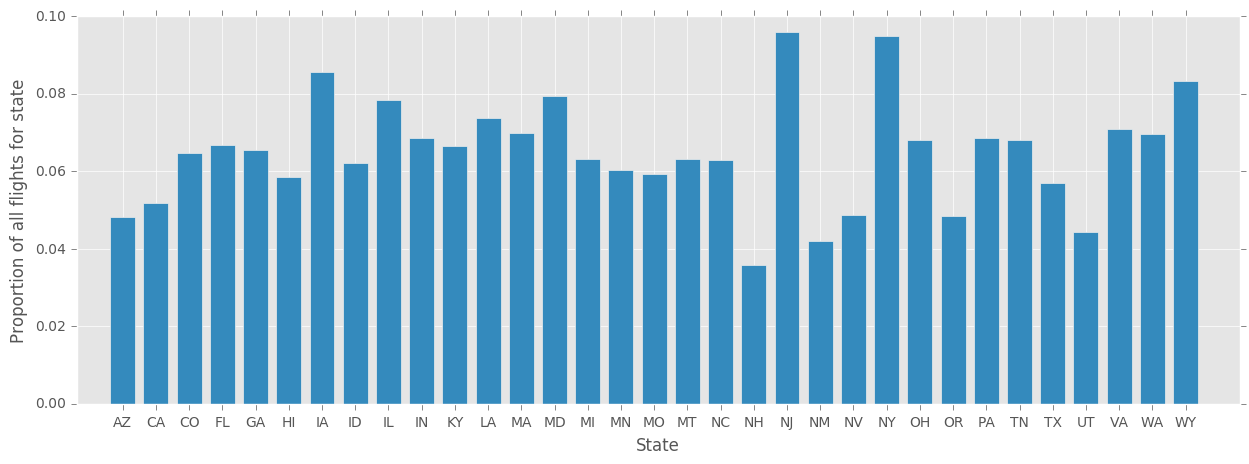

In [88]:
delays_state = pd.crosstab(flights_weather['Departure_State'],flights_weather['Departure_delay_bin'])
delays_state['total'] = delays_state.sum(1)
delays_state = delays_state[delays_state.total>1000] # consider states who have had at least 1000 flights
delays_state_prop = delays_state.drop('total',axis=1).div(delays_state.sum(axis=1), axis=0)
state_long_delays = delays_state_prop["Long Delay"]
f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
names = state_long_delays.index
idx = np.arange(1,names.size+1)
width=0.75
ax1.bar(idx,state_long_delays.values,width=width); ax1.set_xticklabels(names.tolist()); ax1.set_xticks(idx + width / 2);
ax1.set_xlabel("State"); ax1.set_ylabel("Proportion of all flights for state")
plt.show()

* NJ and NY seem to have the most long delays

### time of day and delays - clean 'Departure_schedule' to datetime object

In [104]:
flights_weather['Departure_schedule'] = flights_weather['Departure_schedule'].astype(str)
def add_0(time):
    if len(time) == 1:
        return '000' + time
    elif len(time) == 2:
        return '00' + time
    elif len(time) == 3:
        return '0'+time
    else:
        return time
flights_weather['Departure_schedule'] = flights_weather['Departure_schedule'].apply(add_0)
flights_weather['Departure_schedule_hour'] = pd.to_datetime(flights_weather['Departure_schedule'], format='%H%M').dt.hour
flights_weather['Time_of_day'] = pd.cut(flights_weather['Departure_schedule_hour'],np.arange(0,30,6),right=False,labels=['Early morning','Morning','Afternoon','Evening'])
flights_weather[['Departure_schedule','Departure_schedule_hour','Time_of_day']].sample(5) # example

,Departure_schedule,Departure_schedule_hour,Time_of_day
110678,0600,6,Morning
298705,0825,8,Morning
221991,0955,9,Morning
71574,1850,18,Evening
355466,0805,8,Morning


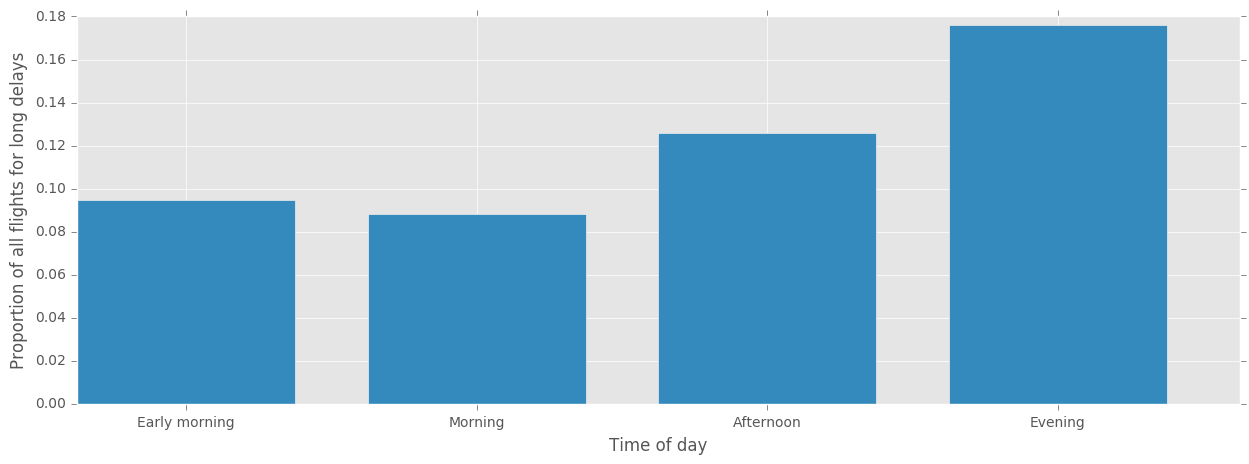

Departure_delay_bin  Long Delay  No delay  Short delay
Time_of_day                                           
Early morning               198      1515          377
Morning                    9536     70529        27941
Afternoon                 19889     86978        50877
Evening                   15751     41472        32251
Departure_delay_bin  Long Delay  No delay  Short delay
Time_of_day                                           
Early morning          0.094737  0.724880     0.180383
Morning                0.088291  0.653010     0.258699
Afternoon              0.126084  0.551387     0.322529
Evening                0.176040  0.463509     0.360451

 P value = 0.000000. reject independence


In [105]:
Time_of_day_delays = Cross_tab(flights_weather['Time_of_day'],flights_weather['Departure_delay_bin'])
time_of_day_delays = Time_of_day_delays.cross_tab
time_of_day_delays_prop = time_of_day_delays.div(time_of_day_delays.sum(axis=1), axis=0)
time_of_day_long_delays = time_of_day_delays_prop["Long Delay"]
f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
names = time_of_day_delays_prop.index
idx = np.arange(1,names.size+1)
width=0.75
ax1.bar(idx,time_of_day_long_delays.values,width=width); ax1.set_xticklabels(names.tolist()); ax1.set_xticks(idx + width / 2);
ax1.set_xlabel("Time of day"); ax1.set_ylabel("Proportion of all flights for long delays")
plt.show()
Time_of_day_delays.chi2_test()

* Evening flights have high proportion of long delays

In [ ]:
time_of_day_delays_prop